## 1. Generative Adversarial Network (GAN) for MNIST


In [ ]:
!pip install torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 899.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt



In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
#Load datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [ ]:
#Generate 10x10 grid
def show_data(img):
  plt.figure(figsize=(10, 10))
  for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(img[i].squeeze(), cmap='gray')
  plt.show()


In [ ]:
train_batch = next(iter(train_loader))
img, labels = train_batch


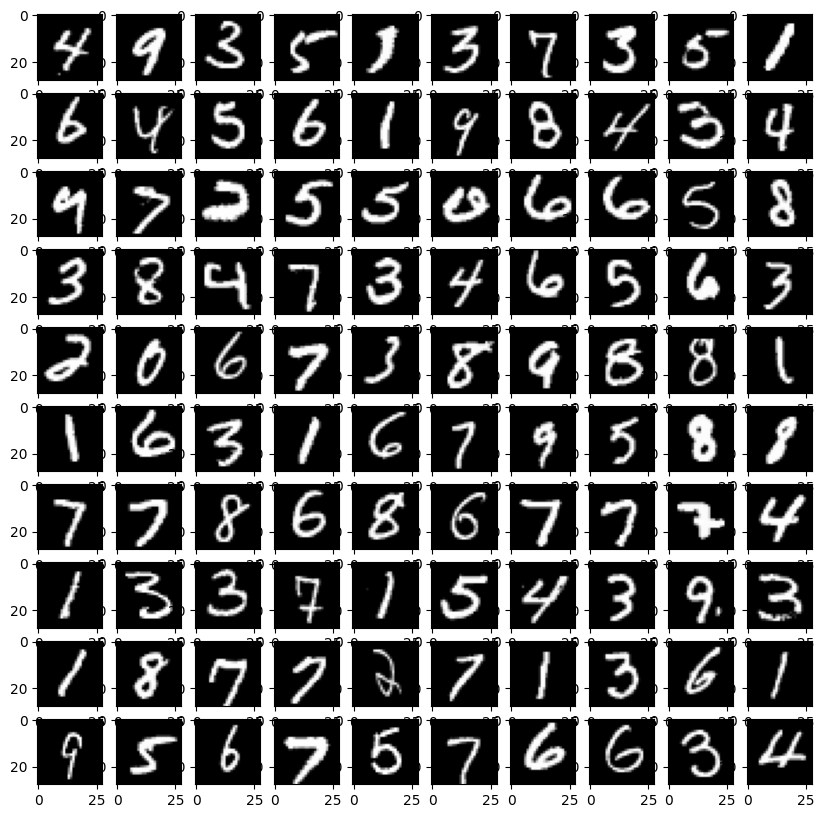

In [ ]:
show_data(img)

In [ ]:
#Neural network of the generator
class Generator(nn.Module):
  def __init__(self, latent_dim = 100):
    super().__init__()
    self.main = nn.Sequential(

    nn.ConvTranspose2d(latent_dim, 128, kernel_size=7, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

  def forward(self, x):
    x = x.view(x.size(0), x.size(1), 1, 1)
    return self.main(x)


In [ ]:
#Neural network of the discriminator
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.main = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.3),

        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Dropout(0.3),

        nn.Flatten(),
        nn.Linear(128 * 7 * 7, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.main(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
#Optimizing parameters
lr = 0.002
betas = (0.5, 0.999)
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=betas)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

In [ ]:
num_epochs = 100
latent_dim = 100
loss_fn = nn.BCELoss()

In [ ]:
#To generate images
def show_generated(generator, latent_dim):
  z = torch.randn(100, latent_dim).to(device)
  generated_images = generator(z).detach().cpu()
  show_data(generated_images)

In [ ]:
g_loss = []
d_loss = []
d_accuracy = []  # Store discriminator accuracy per epoch

for epoch in range(num_epochs):
    epoch_d_loss = 0
    epoch_g_loss = 0
    total_real_correct = 0
    total_fake_correct = 0
    total_samples = 0

    for batch_idx, (real, _) in enumerate(train_loader):
        real = real.to(device)
        batch_size = real.size(0)
        total_samples += batch_size

        # Train Discriminator
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake = generator(noise)

        disc_real = discriminator(real).view(-1)
        loss_real = loss_fn(disc_real, torch.ones_like(disc_real))

        disc_fake = discriminator(fake.detach()).view(-1)
        loss_fake = loss_fn(disc_fake, torch.zeros_like(disc_fake))

        loss_d = (loss_real + loss_fake) / 2
        discriminator.zero_grad()
        loss_d.backward()
        optimizer_d.step()

        # Train Generator
        output = discriminator(fake).view(-1)
        loss_g = loss_fn(output, torch.ones_like(output))
        generator.zero_grad()
        loss_g.backward()
        optimizer_g.step()

        # Accumulate losses for epoch average
        epoch_d_loss += loss_d.item()
        epoch_g_loss += loss_g.item()

        # Calculate accuracy for this batch
        with torch.no_grad():
            # Real images
            real_predictions = torch.sigmoid(disc_real) > 0.5
            real_correct = real_predictions.sum().item()

            # Fake images
            fake_predictions = torch.sigmoid(disc_fake) < 0.5
            fake_correct = fake_predictions.sum().item()

            total_real_correct += real_correct
            total_fake_correct += fake_correct


    # Calculate epoch averages and accuracy
    avg_d_loss = epoch_d_loss / len(train_loader)
    avg_g_loss = epoch_g_loss / len(train_loader)

    # Discriminator accuracy: (correctly classified real + correctly classified fake) / total samples
    discriminator_accuracy = (total_real_correct + total_fake_correct) / (2 * total_samples)

    # Store epoch results
    g_loss.append(avg_g_loss)
    d_loss.append(avg_d_loss)
    d_accuracy.append(discriminator_accuracy)

    # Print epoch summary
    print(f"Epoch [{epoch+1}/{num_epochs}] - D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}, D Accuracy: {discriminator_accuracy:.2%}")

Epoch [1/100] - D Loss: 0.4854, G Loss: 1.6819, D Accuracy: 50.00%
Epoch [2/100] - D Loss: 0.4969, G Loss: 1.6635, D Accuracy: 50.00%
Epoch [3/100] - D Loss: 0.4900, G Loss: 1.6638, D Accuracy: 50.00%
Epoch [4/100] - D Loss: 0.4853, G Loss: 1.6897, D Accuracy: 50.00%
Epoch [5/100] - D Loss: 0.4727, G Loss: 1.7818, D Accuracy: 50.00%
Epoch [6/100] - D Loss: 0.4566, G Loss: 1.8746, D Accuracy: 50.00%
Epoch [7/100] - D Loss: 0.4610, G Loss: 1.8574, D Accuracy: 50.00%
Epoch [8/100] - D Loss: 0.4639, G Loss: 1.8782, D Accuracy: 50.00%
Epoch [9/100] - D Loss: 0.4430, G Loss: 1.9900, D Accuracy: 50.00%
Epoch [10/100] - D Loss: 0.4539, G Loss: 1.9354, D Accuracy: 50.00%
Epoch [11/100] - D Loss: 0.4458, G Loss: 1.9669, D Accuracy: 50.00%
Epoch [12/100] - D Loss: 0.4470, G Loss: 1.9593, D Accuracy: 50.00%
Epoch [13/100] - D Loss: 0.4366, G Loss: 2.0580, D Accuracy: 50.00%
Epoch [14/100] - D Loss: 0.4070, G Loss: 2.2143, D Accuracy: 50.00%
Epoch [15/100] - D Loss: 0.4211, G Loss: 2.2132, D Accura

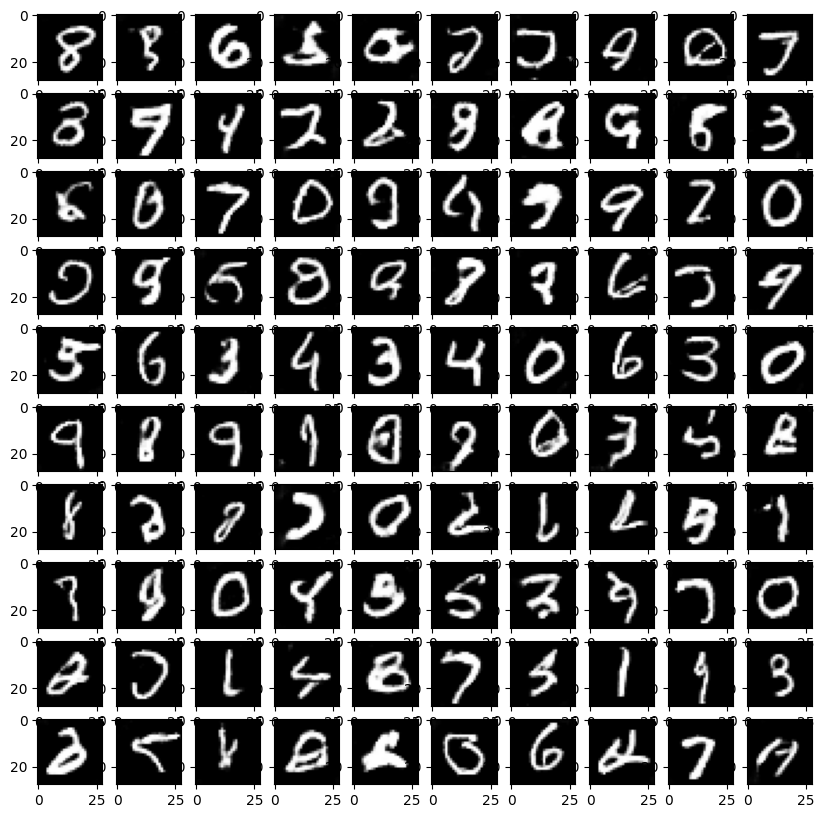

In [ ]:
#10x10 grid
show_generated(generator, latent_dim)

In [ ]:
import pickle
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Save the trained Generator model to Google Drive
with open('/content/drive/MyDrive/new/G.pkl', 'wb') as f:
    pickle.dump(generator, f)

# Save the trained Discriminator model to Google Drive
with open('/content/drive/MyDrive/new/D.pkl', 'wb') as f:
    pickle.dump(discriminator, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Create and annotate a fake data set

In [ ]:
import os
import torch
import torchvision.utils as vutils
from PIL import Image
import numpy as np

save_dir = "/content/drive/MyDrive/Fake_Digits_new"
os.makedirs(save_dir, exist_ok=True)

n_images = 300     # generate extra to filter out malformed ones
z_dim = 100

# Generate fake images
generator.eval()  # set generator to eval mode
with torch.no_grad():
    for idx in range(1, n_images + 1):
        # Sample latent vector
        z = torch.randn(1, z_dim, device=device)

        # Generate fake image
        fake_img = generator(z).detach().cpu()

        # Convert to PIL image
        img_tensor = fake_img.squeeze(0)
        img_pil = transforms.ToPILImage()(img_tensor)  # 0-1 range

        # File names with 4-digit index
        img_filename = f"{idx:04d}.png"
        z_filename = f"{idx:04d}.txt"

        # Save image
        img_pil.save(os.path.join(save_dir, img_filename))

        # Save latent vector z
        np.savetxt(os.path.join(save_dir, z_filename), z.cpu().numpy(), fmt="%.6f")


## 3. Evaluate the new fake data set



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# reproducibility
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Data transforms (MNIST mean/std were used)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # standard MNIST normalization
])

#Datasets and loaders
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=1000, shuffle=False, num_workers=2, pin_memory=True)

#Small CNN definition
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = SimpleCNN().to(device)

#Loss + optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#Training and evaluation loops
def train_one_epoch(model, device, loader, optimizer, epoch):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)

    avg_loss = running_loss / len(loader)
    acc = 100.0 * correct / total
    print(f"Epoch {epoch} - Training loss: {avg_loss:.4f}, Training Accuracy: {acc:.2f}%")
    return acc


def evaluate(model, device, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    acc = 100.0 * correct / total
    print(f"Testing Accuracy: {acc:.2f}%")
    return acc


#Run training

num_epochs = 5
best_acc = 0.0
for epoch in range(1, num_epochs + 1):
    train_one_epoch(model, device, train_loader, optimizer, epoch)
    acc = evaluate(model, device, test_loader)
    # save if improved
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "mnist_cnn_best.pth")
        print("Saved improved model.")

print("Training finished. Best test accuracy:", best_acc)


In [ ]:
import torch
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Save the trained Classifier model to Google Drive
torch.save(model.state_dict(), '/content/drive/MyDrive/C.pth')

Create & test S1 dataset

In [ ]:
fake_dir = "/content/drive/MyDrive/classified_digits_new"

fake_dict = {}

for digit in sorted(os.listdir(fake_dir)):
    digit_path = os.path.join(fake_dir, digit)
    if os.path.isdir(digit_path) and digit.isdigit():
        indices = []
        for fname in sorted(os.listdir(digit_path)):
            if fname.endswith(".png"):
                # Remove file extension and leading zeros if needed
                index = os.path.splitext(fname)[0]
                indices.append(index)
        fake_dict[digit] = indices

print(fake_dict)

{'0': ['0109', '0145', '0151', '0161', '0193', '0203', '0239', '0241', '0271', '0277', '0282'], '1': ['0021', '0077', '0088', '0103', '0106', '0185', '0188', '0211', '0247', '0256'], '2': ['0003', '0075', '0140', '0148', '0163', '0166', '0201'], '3': ['0012', '0020', '0167', '0168', '0169', '0215', '0218', '0232', '0258', '0300'], '4': ['0022', '0036', '0050', '0164', '0237'], '5': ['0078', '0149', '0174', '0210', '0224', '0234', '0272', '0298'], '6': ['0008', '0015', '0093', '0133', '0137', '0172', '0244', '0250', '0264', '0291'], '7': ['0011', '0026', '0033', '0072', '0080', '0110', '0114', '0131', '0158', '0181', '0192', '0208', '0229', '0245', '0248', '0283'], '8': ['0004', '0046', '0056', '0059', '0064', '0154', '0179', '0235', '0236', '0259'], '9': ['0027', '0049', '0076', '0122', '0138', '0191', '0202', '0221', '0227', '0231', '0257', '0267', '0290']}


In [ ]:
import os
import pickle
import numpy as np
from PIL import Image
from sklearn.metrics import classification_report, accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from google.colab import drive


In [ ]:
#Define CNN class again to load pkl file
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Load the trained model from Google Drive using pickle
with open("/content/drive/MyDrive/C.pkl", "rb") as f:
    clf = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clf.to(device)  # Move the model to the appropriate device
clf.eval()  # Set the model to evaluation mode

X = []
y_true = []

for label, indices in fake_dict.items():
    for idx in indices:
        img_path = os.path.join(fake_dir, label, f"{idx}.png")

        # Load image as grayscale
        img = Image.open(img_path).convert("L")
        img = img.resize((28, 28))  # MNIST size
        img_array = np.array(img) / 255.0
        img_array = img_array.flatten()

        X.append(img_array)
        y_true.append(int(label))

X = np.array(X)
y_true = np.array(y_true)

#Predict and evaluate

# Convert to PyTorch tensor
X_tensor = torch.FloatTensor(X).to(device)
X_tensor = X_tensor.view(-1, 1, 28, 28)  # Reshape

# Make predictions
with torch.no_grad():
    outputs = clf(X_tensor)  # Forward pass

    # If your model outputs logits, convert to probabilities and get predictions
    if outputs.dim() > 1:  # Multi-class output
        _, y_pred = torch.max(outputs, 1)  # Get class with highest probability
        y_pred = y_pred.cpu().numpy()  # Convert to numpy array
    else:  # Binary output
        y_pred = (torch.sigmoid(outputs) > 0.5).int()
        y_pred = y_pred.cpu().numpy()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Accuracy: 0.96

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        10
           2       1.00      0.71      0.83         7
           3       0.83      1.00      0.91        10
           4       1.00      1.00      1.00         5
           5       0.88      0.88      0.88         8
           6       1.00      0.90      0.95        10
           7       1.00      1.00      1.00        16
           8       0.91      1.00      0.95        10
           9       1.00      1.00      1.00        13

    accuracy                           0.96       100
   macro avg       0.96      0.95      0.95       100
weighted avg       0.96      0.96      0.96       100



Create & test S0 datatset

In [ ]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random

# Define the transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

indices = random.sample(range(len(test_dataset)), 100)
S0 = torch.utils.data.Subset(test_dataset, indices)
S0_loader = torch.utils.data.DataLoader(S0, batch_size=1, shuffle=False)

# Calculate error
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    clf.eval()
except NameError:
    clf = SimpleCNN() # Instantiate the model
    try:
        clf.load_state_dict(torch.load("/content/drive/MyDrive/C.pth", map_location=device))
    except FileNotFoundError:
        exit()
    clf.to(device)
    clf.eval()


correct = 0
total = 0

with torch.no_grad():
    for data, target in S0_loader:
        data, target = data.to(device), target.to(device)
        outputs = clf(data)
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

# Calculate error
accuracy = correct / total
error_rate = 1 - accuracy

print(f"Classification Error: {error_rate:.2%}")
print(f"Errors: {total - correct} out of {total}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 475kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.99MB/s]


Classification Error: 1.00%
Errors: 1 out of 100
